In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
import pandas as pd

image_path = '/mnt/d/datasets/INBREAST/inbreast/images'
crop_size = [224, 224]

In [2]:
def crop_black_part(image_array):
    # Cropping every column that doesn't contain tissue
    not_dark = np.where(image_array != 0, 1, 0)
    tissue_distrib_x = np.sum(not_dark, axis=0) / not_dark.shape[0]
    tissue_distri_y = np.sum(not_dark, axis=1) / not_dark.shape[1]
    is_tissue_x = np.where(tissue_distrib_x > 0.1, 1, 0)
    is_tissue_y = np.where(tissue_distri_y > 0.1, 1, 0)

    first_tissue_x = np.where(is_tissue_x == 1)[0][0]
    last_tissue_x = np.where(is_tissue_x == 1)[-1][-1]
    first_tissue_y = np.where(is_tissue_y == 1)[0][0]
    last_tissue_y = np.where(is_tissue_y == 1)[-1][-1]

    return image_array[first_tissue_y:last_tissue_y,first_tissue_x:last_tissue_x]

In [3]:
model = tf.keras.models.load_model('/mnt/d/datasets/INBREAST/results/resnet50.h5')

In [9]:
positive = []
negative = []

test = tf.keras.preprocessing.image_dataset_from_directory(
    '/mnt/d/datasets/INBREAST/split/test', image_size=(224, 224), batch_size=6, label_mode="binary")


# for file in os.listdir('/mnt/d/datasets/INBREAST/inbreast/split/test/positive')[::10]:
#     image = Image.open('/mnt/d/datasets/INBREAST/inbreast/split/test/positive' + file)
#     
#     result = model.predict()
#     
#     positive.append(file)
#     
# for file in os.listdir('/mnt/d/datasets/INBREAST/inbreast/split/test/negative'):
#     positive.append(file)

Found 492 files belonging to 2 classes.


NameError: name 'pd' is not defined

In [11]:
df_test = pd.DataFrame(test)

In [ ]:
df_test

In [4]:
step = 50

crops_y = 0
processed_y = 0

# Crop picture to equal parts
image = Image.open(os.path.join(image_path, os.listdir(image_path)[0]))    
image_array = np.array(image)        

crop_array = crop_black_part(image_array) 

width = math.ceil(crop_array.shape[1] / step)
height = math.ceil(crop_array.shape[0] / step)

heat = np.zeros([height, width])

while processed_y + crop_size[0] < crop_array.shape[0]:       
    crops_x = 0
    processed_x = 0
    
    while processed_x + crop_size[1] < crop_array.shape[1]:               
    
        grid_array = crop_array[processed_y : processed_y + crop_size[0], 0 : crop_size[1]]              
            
        image_gray = Image.fromarray(grid_array)    
        image_rgb = Image.merge('RGB', (image_gray, image_gray, image_gray))
        grid_array = np.expand_dims(np.array(image_rgb), axis=0)
        
        heat[crops_y, crops_x] = model.predict(grid_array, verbose=0)[0][0]
        
        processed_x += step
        crops_x += 1 
        
    processed_y += step
    crops_y += 1
    
    if crops_y % 10 == 0:
        percent = (crops_y / height) * 100
        print(f"{percent}% done")

39 67


KeyboardInterrupt: 

In [ ]:
Xi = []
Yi = []
Zi = []

for y, row in enumerate(heat):
    for x, num in enumerate(row):
        Xi.append(x * 50)
        Yi.append(y * 50)
        Zi.append(num)


In [22]:
print(Zi)

[5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 0.0, 0.0, 0.0, 0.0, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.410481094259012e-07, 5.41048109425

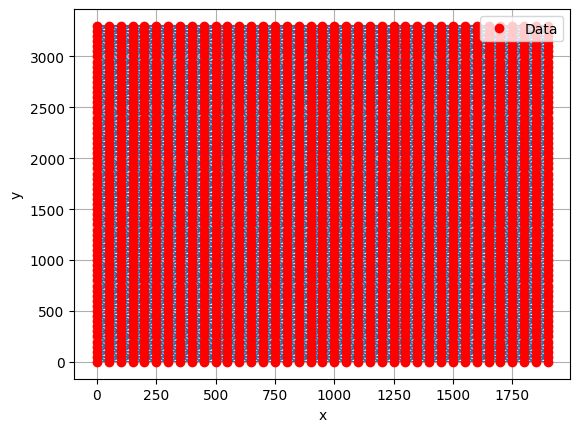

In [12]:
Pi = np.array([Xi, Yi]).transpose()
tri = Delaunay(Pi)
plt.triplot(Xi, Yi , tri.simplices.copy())
plt.plot(Xi, Yi, "or", label = "Data")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
N = len(Xi)
x = np.linspace(0., np.max(Xi), N)
y = np.linspace(0., np.max(Yi), N)
X, Y = np.meshgrid(x, y)
P = np.array([X.flatten(), Y.flatten() ]).transpose()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


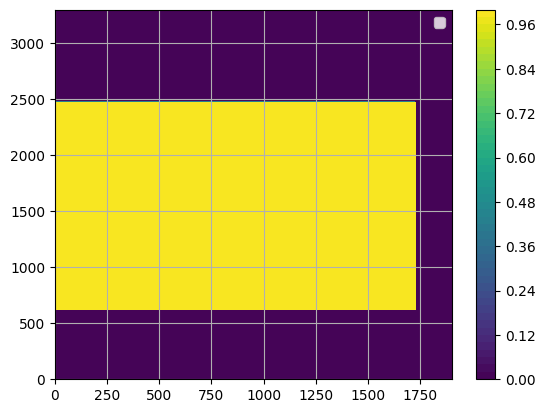

In [18]:
Z_nearest = griddata(Pi, Zi, P, method = "nearest").reshape([len(Yi), N])
plt.contourf(X, Y, Z_nearest, 50)
#plt.plot(Xi, Yi, "or", label = "Data")
plt.colorbar()
plt.legend()
plt.grid()
plt.show()

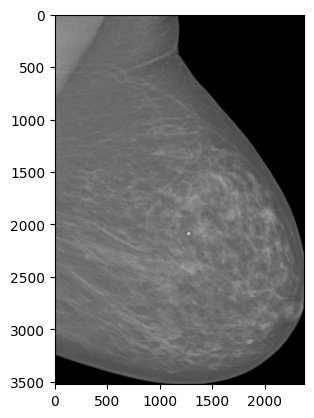

In [35]:
# Crop picture to equal parts
image = Image.open(os.path.join(image_path, file))
image_array = np.array(image)
tissue_array = crop_black_part(image_array)

# Every pixel will be represented two times except the first and last crop_size[1] / 2 pixels of the width
x_crops = math.ceil(2 * (tissue_array.shape[1] - (crop_size[1])) / (crop_size[1]))
y_crops = math.ceil(tissue_array.shape[0] / crop_size[0])

x_diff = tissue_array.shape[1] - (round(tissue_array.shape[1] / 112)) * 112
y_diff = tissue_array.shape[0] - y_crops * crop_size[0]

crop_array = 